### Desde https://causalnex.readthedocs.io/

# Tutorial CausalNex 


Este tutorial es un ejemplo de uso de CausalNex para estimar si un estudiante aprobabará o suspenderá un examen, basándose en características como relaciones familiares, soporte escolar y otros. Se usará el dataset de [Student Performance](https://archive.ics.uci.edu/ml/datasets/Student+Performance) publicado en [UCI Machine Learning Repository.](http://archive.ics.uci.edu/ml/index.php).

La características del dataset son:

+ 1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
+ 2 sex - student's sex (binary: 'F' - female or 'M' - male)
+ 3 age - student's age (numeric: from 15 to 22)
+ 4 address - student's home address type (binary: 'U' - urban or 'R' - rural)
+ 5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
+ 6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
+ 7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
+ 8 Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
+ 9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
+ 10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
+ 11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
+ 12 guardian - student's guardian (nominal: 'mother', 'father' or 'other')
+ 13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
+ 14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
+ 15 failures - number of past class failures (numeric: n if 1<=n<3, else 4)
+ 16 schoolsup - extra educational support (binary: yes or no)
+ 17 famsup - family educational support (binary: yes or no)
+ 18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
+ 19 activities - extra-curricular activities (binary: yes or no)
+ 20 nursery - attended nursery school (binary: yes or no)
+ 21 higher - wants to take higher education (binary: yes or no)
+ 22 internet - Internet access at home (binary: yes or no)
+ 23 romantic - with a romantic relationship (binary: yes or no)
+ 24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
+ 25 freetime - free time after school (numeric: from 1 - very low to 5 - very high)
+ 26 goout - going out with friends (numeric: from 1 - very low to 5 - very high)
+ 27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
+ 28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
+ 29 health - current health status (numeric: from 1 - very bad to 5 - very good)
+ 30 absences - number of school absences (numeric: from 0 to 93)
+ 31 G1 - first period grade (numeric: from 0 to 20)
+ 31 G2 - second period grade (numeric: from 0 to 20)
+ 32 G3 - final grade (numeric: from 0 to 20, output target)

## Estructura 

Se puede definir la estructura de una red bayesiana (Bayesian Network - BN) basándose en el machine learning, el conocimiento experto o una combinación de ambos, donde expertos y algoritmos contribuyen igualmente a la solución del problema.

Sin importar de qué manera sea, es fundamental validar la estructura evaluando la BN (esto se verá luego). En ésta sección nos centraremos en definir la estructura.



## Estructura desde el conocimiento experto

Podemos definir manualmente la estructura del modelo especificando las relaciones entre diferentes características.

Primero, debemos crear una estructura vacía.

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
from causalnex.structure import StructureModel

sm=StructureModel()
sm

Ahora, podemos especificar las relaciones entre características. Por ejemplo, supongamos que el experto nos dice que existe la siguiente relación causal: 

+ health -> absences   (salud -> ausencias)
+ health -> G1         (salud -> notas del primer semestre)


Podemos añadir esas relaciones a la estructura de nuestro modelo:

In [3]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

## Visualizando la estructura

Podemos examinar el StructureModel observando la salida de sm.edges

In [4]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

pero a menudo es más intuitivo visualizarlo. CausalNex tiene un módulo de plot que nos permite hacer eso:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

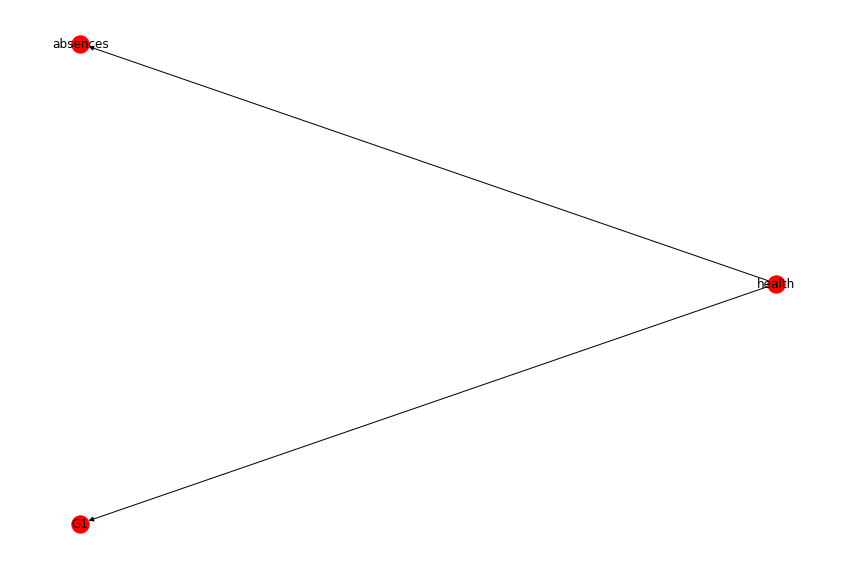

In [7]:
plt.rcParams['figure.figsize']=(12.0, 8.0)

from causalnex.plots import plot_structure

_, _, _ = plot_structure(sm)

In [ ]:
help(plot_structure)

## Estructura desde ML

Según crece el número de variables, o cuando no existe conocimiento experto, puede volverse tedioso definir toda la estructura de manera manual. Podemos usar CausalNex para extraer la estructura desde los datos. El algoritmo que se va a usar aquí es [NOTEARS](https://arxiv.org/abs/1803.01422).

Para extraer la estructura, podemos usar todo el dataframe. No siempre es necesario usar train_test_split, dado que la estructura es un esfuerzo conjunto entre máquina y expertos.

Pero antes de empezar, debemos procesar nuestros datos para poder alimentar el algoritmo.

## Preparando los datos

In [ ]:
import pandas as pd


data=pd.read_csv('data/student-por.csv', delimiter=';')
data.head()

Observando los datos, podemos ver que existen características numéricas y no-numéricas(categóricas). Podemos eliminar ciertas características 'sensibles' como el género, que no queremos usar en nuestro modelo.

In [ ]:
drop_col=['school', 'sex', 'age', 'Mjob', 'Fjob', 'reason', 'guardian']
data=data.drop(columns=drop_col)
data.head()

Ahora, queremos que toda nuestra data sea numérica, puesto que es lo que espera el algoritmo NOTEARS. Podemos hacer esto con LabelEncoding.

In [ ]:
import numpy as np

struct_data=data.copy()

non_numeric_columns=list(struct_data.select_dtypes(exclude=[np.number]).columns)
non_numeric_columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

for col in non_numeric_columns:
    struct_data[col]=le.fit_transform(struct_data[col])

struct_data.head()

Llegados hasta aquí, ya podemos aplicar NOTEARS para que aprenda la estructura...

In [ ]:
from causalnex.structure.notears import from_pandas


sm=from_pandas(struct_data)

... y visualizarla.

In [ ]:
plt.rcParams['figure.figsize']=(12.0, 8.0)

_, _, _ = plot_structure(sm);

La razón por la que tenemos un grafo completamente conectado es que no hemos aplicado un umbral(threshold) a las aristas 'débiles'. Esto se puede hacer con dos métodos, de maneras distintas, o se especifica el valor del parámetro w_threshold en el método from_pandas, o podemos eliminar las aristas con el método remove_edges_below_threshold.

In [ ]:
plt.rcParams['figure.figsize']=(12.0, 8.0)


sm.remove_edges_below_threshold(0.8)

_, _, _ = plot_structure(sm);

En esta estructura, podemos ver que hay algunas relaciones que parecen ser intuitivamente correctas:

+ Pstatus afecta a famrel - si los padres están separados, the quality of family relationship may be poor as a result.
+ internet afecta a absences - The presence of internet at home may cause student to skip class.
+ studytime afecta a G1 - longer studytime should have a positive impact on a student’s result.

However, there are some relationships that are certainly incorrect:

+ higher affects Mother’s education - this relationship does not make sense as students who wants to pursue higher education does not affect mother’s education. It could be the other way round.


To avoid these erroneous relationships, we can re-run structure learning with some added constraints:

In [ ]:
plt.rcParams['figure.figsize']=(12.0, 8.0)


sm=from_pandas(struct_data, tabu_edges=[("higher", "Medu")], w_threshold=0.8)

_, _, _ = plot_structure(sm);

## Modifying the Structure

To correct erroneous relationships, we can incorporate domain knowledge into the model after structure learning. We can modify the structure model through adding and deleting the edges. For example, we can add and remove edges as:

In [ ]:
sm.add_edge("failures", "G1")

sm.remove_edge("Pstatus", "G1")

sm.remove_edge("address", "G1")

We can now visualise our updated structure to confirm it looks reasonable.

In [ ]:
plt.rcParams['figure.figsize']=(12.0, 8.0)

_, _, _ = plot_structure(sm);

We can see there are two separate subgraphs here in the visualisation plot: Dalc->Walc and the other big subgraph. We can retrieve the largest subgraph easily by calling the StructureModel function get_largest_subgraph().

In [ ]:
plt.rcParams['figure.figsize']=(12.0, 8.0)


sm=sm.get_largest_subgraph()

_, _, _ = plot_structure(sm);

After deciding on how the final structure model should look, we can instantiate a BayesianNetwork.

In [ ]:
from causalnex.network import BayesianNetwork

bn=BayesianNetwork(sm)
bn

We are now ready to move on to learning the conditional probability distribution of different features in the BayesianNetwork.

## Fitting the Conditional Distribution of the Bayesian Network

### Preparing the Discretised Data

Bayesian Networks in CausalNex support only discrete distributions. Any continuous features, or features with a large number of categories, should be discretised prior to fitting the Bayesian Network. Models containing variables with many possible values will typically be badly fit, and exhibit poor performance.

For example, consider P(G2 | G1), where G1 and G2 have possible values 0 to 20. The discrete conditional probability distribution is therefore specified using 21x21 (441) possible combinations - most of which we will be unlikely to observe.

CausalNex provides a few helper methods to make discretisation easier. Let’s start by reducing the number of categories in some of the categorical features by combining similar values. We will make numeric features categorical by discretisation, and then give the buckets meaningful labels.

### Cardinality of Categorical Features

To reduce the cardinality of categorical features we can define a map {old_value: new_value}, and use this to update the feature. For example, in the studytime feature, we make the studytime which is more than 2 (2 means 2 to 5 hours here, see https://archive.ics.uci.edu/ml/datasets/Student+Performance) into long-studytime, and the rest into short-studytime.

In [ ]:
discretised_data=data.copy()

data_vals={col: data[col].unique() for col in data.columns}


failures_map={v: 'no-failure' if v==[0]
              else 'have-failure' for v in data_vals['failures']}


studytime_map={v: 'short-studytime' if v in [1,2]
               else 'long-studytime' for v in data_vals['studytime']}

Once we have defined our maps {old_value: new_value} we can update each feature, applying the mapping transformation.

In [ ]:
discretised_data["failures"]=discretised_data["failures"].map(failures_map)

discretised_data["studytime"]=discretised_data["studytime"].map(studytime_map)

### Discretising Numeric Features

To make numeric features categorical, they must first be discretised. CausalNex provides a helper class causalnex.discretiser.Discretiser, which supports several discretisation methods. For our data the fixed method will be applied, providing static values that define the bucket boundaries. For example, absences will be discretised into the buckets < 1, 1 to 9, and >=10. Each bucket will be labelled as an integer from zero.

In [ ]:
from causalnex.discretiser import Discretiser



discretised_data["absences"]=Discretiser(method="fixed",
                             numeric_split_points=[1, 10]).transform(discretised_data["absences"].values)

discretised_data["G1"]=Discretiser(method="fixed",
                                   numeric_split_points=[10]).transform(discretised_data["G1"].values)

discretised_data["G2"]=Discretiser(method="fixed",
                                   numeric_split_points=[10]).transform(discretised_data["G2"].values)

discretised_data["G3"]=Discretiser(method="fixed",
                                   numeric_split_points=[10]).transform(discretised_data["G3"].values)

### Create Labels for Numeric Features

To make the discretised categories more readable, we can map the category labels onto something more meaningful in the same way that we mapped category feature values.

In [ ]:
absences_map = {0: "No-absence", 1: "Low-absence", 2: "High-absence"}

G1_map = {0: "Fail", 1: "Pass"}
G2_map = {0: "Fail", 1: "Pass"}
G3_map = {0: "Fail", 1: "Pass"}

discretised_data["absences"] = discretised_data["absences"].map(absences_map)
discretised_data["G1"] = discretised_data["G1"].map(G1_map)
discretised_data["G2"] = discretised_data["G2"].map(G2_map)
discretised_data["G3"] = discretised_data["G3"].map(G3_map)

## Train / Test Split
Like many other machine learning models, we will use a train and test split to help us validate our findings.

In [ ]:
# Split 90% train and 10% test
from sklearn.model_selection import train_test_split

train, test=train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

## Model Probability

With the learnt structure model from earlier and the discretised data, we can now fit the probability distrbution of the Bayesian Network. The first step in this is specifying all of the states that each node can take. This can be done either from data, or providing a dictionary of node values. We use the full dataset here to avoid cases where states in our test set do not exist in the training set. For real-world applications, these states may need to be provided using the dictionary method.

In [ ]:
bn=bn.fit_node_states(discretised_data)

## Fit Conditional Probability Distributions

The fit_cpds method of BayesianNetwork accepts a dataset to learn the conditional probablilty distributions (CPDs) of each node, along with a method of how to do this fit.

In [ ]:
bn=bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

Once we have the the CPDs, we can inspect them through the cpds property, which is a dictionary of node->cpd.

In [ ]:
bn.cpds["G1"]

The CPD dictionaries are multi-indexed, and so the loc function can be a useful way to interact with them:

## Predict the State given the Input Data

The predict method of BayesianNetwork allows us to make predictions based on the data using the learnt Bayesian Network. For example, we want to predict if a student fails or passes their exam based on the input data. Imagine we have an incoming student data that looks like this:

In [ ]:
discretised_data.loc[18, discretised_data.columns != 'G1']

Based on these data, we want to predict if this student fails their exam. Intuitively, we would expect this student to fail because they spend a shorter amount of time on their study and have failed in the past. Let’s see how our Bayesian Network performs on this:

predictions=bn.predict(discretised_data, "G1")

In [ ]:
print('The prediction is \'{prediction}\''.format(prediction=predictions.loc[18, 'G1_prediction']))

The prediction by the Bayesian Network turns out to be a Fail. Let’s compare this to the ground truth:

In [ ]:
print('The ground truth is \'{truth}\''.format(truth=discretised_data.loc[18, 'G1']))

which turns out to be the same.

## Model Quality
To evaluate the quality of the model that has been learned, CausalNex supports two main approaches: Classification Report and Reciever Operating Characteristics (ROC) / Area Under the ROC Curve (AUC). In this section each will be discussed.

### Classification Report
To obtain a classification report using a BN, we need to provide a test set, and the node we are trying to classify. The report will predict the target node for all rows in the test set, and evaluate how well those predictions are made.

In [ ]:
from causalnex.evaluation import classification_report

classification_report(bn, test, "G1")

This report shows that the model we have defined is able to classify whether a student passes their exam reasonably well.

For the predictions where the student fails, the precision is good, but recall is bad. This implies that we can rely on predictions for this class when they are made, but we are likely to miss some of the predictions we should have made. Perhaps these missing predictions are as a result of something missing in our structure - this could be an interesting area to explore.

### ROC / AUC
Reciever Operating Characteristics (ROC), and the Area Under the ROC Curve (AUC) can be obtained using the roc_auc method within the CausalNex metrics module. Again, a test set and target node must be provided. The ROC curve is computed by micro-averaging predictions made across all states (classes) of the target node.

In [ ]:
from causalnex.evaluation import roc_auc

roc, auc=roc_auc(bn, test, "G1")
auc

The AUC value for our model is high, giving us confidence in the performance.

## Querying Marginals
After iterating over our model structure, CPDs, and validating our model quality, we can query our model under defferent observation to gain insights.

### Baseline Marginals
To query the model for baseline marginals that reflect the population as a whole, a query method can be used. First let’s update our model using the complete dataset, since the one we currently have was only built from training data.

In [ ]:
bn=bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

We can safely ignore these warnings, which let us know we are replacing the previously existing CPDs.

For inference, we must create a new InferenceEngine from our BayesianNetwork, which lets us query the model. The query method will compute the marginal likelihood of all states for all nodes

In [ ]:
from causalnex.inference import InferenceEngine

ie=InferenceEngine(bn)

marginals=ie.query()
marginals["G1"]

The output observed tells us that P(G1=Fail) = 0.25, and the P(G1=Pass) = 0.75. As a quick sanity check, we can compute what proportion of our dataset are Fail, which should be approximately the same.

In [ ]:
import numpy as np


labels, counts=np.unique(discretised_data["G1"], return_counts=True)

list(zip(labels, counts))

The proportion of the students who fail is 157 / (157+492) = 0.242 - which is close to our computed marginal likelihood.

## Marginals after Observations

We can also query the marginal likelihood of states in our network given some observations. These observations can be made anywhere in the network, and their impact will be propagated through to the node of interest.

Let’s look at the difference in the likelihood of G1 based on studytime.

In [ ]:
marginals_short=ie.query({"studytime": "short-studytime"})
marginals_long=ie.query({"studytime": "long-studytime"})

print("Marginal G1 | Short Studtyime", marginals_short["G1"])
print("Marginal G1 | Long Studytime", marginals_long["G1"])

Based on our data we can see that students who study longer are more likely to pass their exam.

## Do Calculus

CausalNex also supports simple Do-Calculus, allowing as to specify interventions. In this section we will take a look at the supported methods, and what they mean.

### Updating a Node Distribution

We can apply an intervention to any node in our data, updating its distribution using a do operator. This can be thought of as asking our model “What if” something were different. For example, we could ask what would happen if 100% of students wanted to go on to do higher education.

In [ ]:
print("distribution before do", ie.query()["higher"])

ie.do_intervention("higher",
                   {'yes': 1.0,
                    'no': 0.0})


print("distribution after do", ie.query()["higher"])

### Resetting a Node Distribution

We can reset any interventions that we make by using the reset_intervention method, and providing the node that we want to reset.

In [ ]:
ie.reset_do("higher")

### Effect of Do on Marginals

We can again use query to examine the effect that an intervention has on our marginal likelihoods. In this case, we can look at how the likelihood of achieving a pass changes if 100% of students wanted to do higher education.

In [ ]:
print("marginal G1", ie.query()["G1"])
ie.do_intervention("higher",
                   {'yes': 1.0,
                    'no': 0.0})
print("updated marginal G1", ie.query()["G1"])

In this case, we can see that if 100% of students wanted to do higher education (as opposed to 90% in our data population), then we estimate that pass rate would increase from 74.7% to 79.3%.